<a href="https://colab.research.google.com/github/alonsomoros/colab/blob/main/Practica_2_2_MNIST_ACGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install tensorflow==2.13
!pip install keras==2.13.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

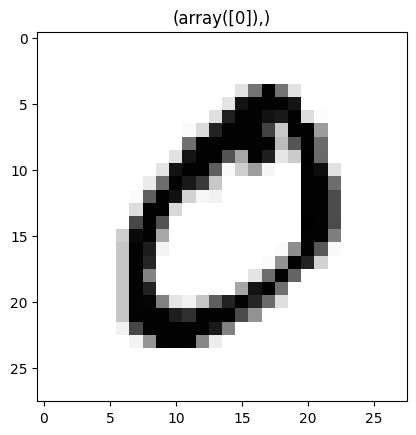

(60000, 28, 28)


In [27]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

plt.imshow(X_train[1], cmap = 'Greys')
plt.title(np.where(y_train[1]==1))
plt.show()
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [28]:
X_train = X_train.astype('float32')/127.5 -1

X_train = np.expand_dims(X_train, axis=3)

# Generator definition

In [29]:
def create_generator():
    input_z = Input(shape=(100))

    # Introducir una nueva entrada input_label y concatenerla con input_z para formar la entrada de la red
    input_label = Input(shape=(10,))
    combined_input = Concatenate()([input_z, input_label])

    # Cambiar el modelo para que ahora admita las dos entradas

    x = Dense(7 * 7 * 128, activation='relu')(combined_input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    output_img = Conv2D(1, kernel_size=3, padding='same', activation='tanh')(x)

    generator = Model([input_z, input_label], output_img)

    return generator

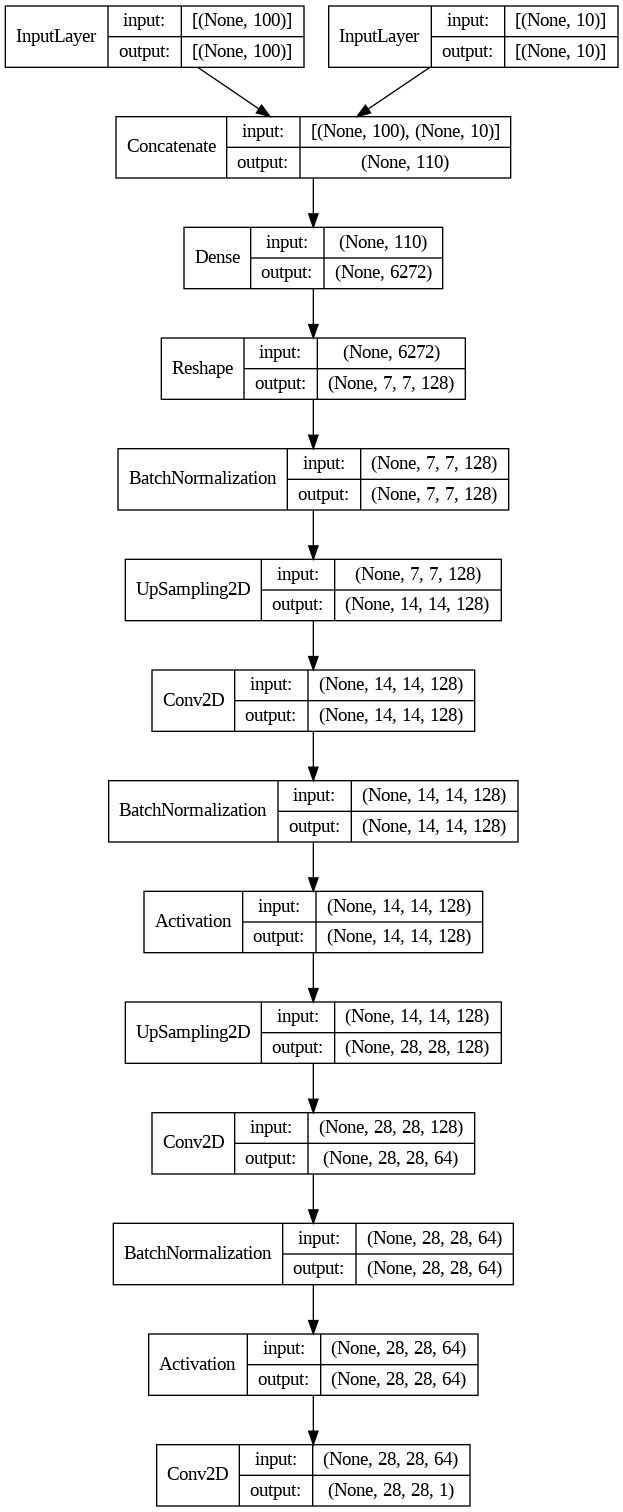

In [30]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

# Discriminator definition

In [31]:
def create_discriminator():
    input_img = Input(shape=(28, 28, 1))

    # Introducir una nueva salida output_label que clasifique la etiqueta de las imágenes
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)

    output_validity = Dense(1, activation='sigmoid', name='validity')(x)

    output_label = Dense(10, activation='softmax', name='label')(x)

    # Cambiar el modelo para que ahora genere dos salidas
    discriminator = Model(input_img, [output_validity, output_label])

    return discriminator

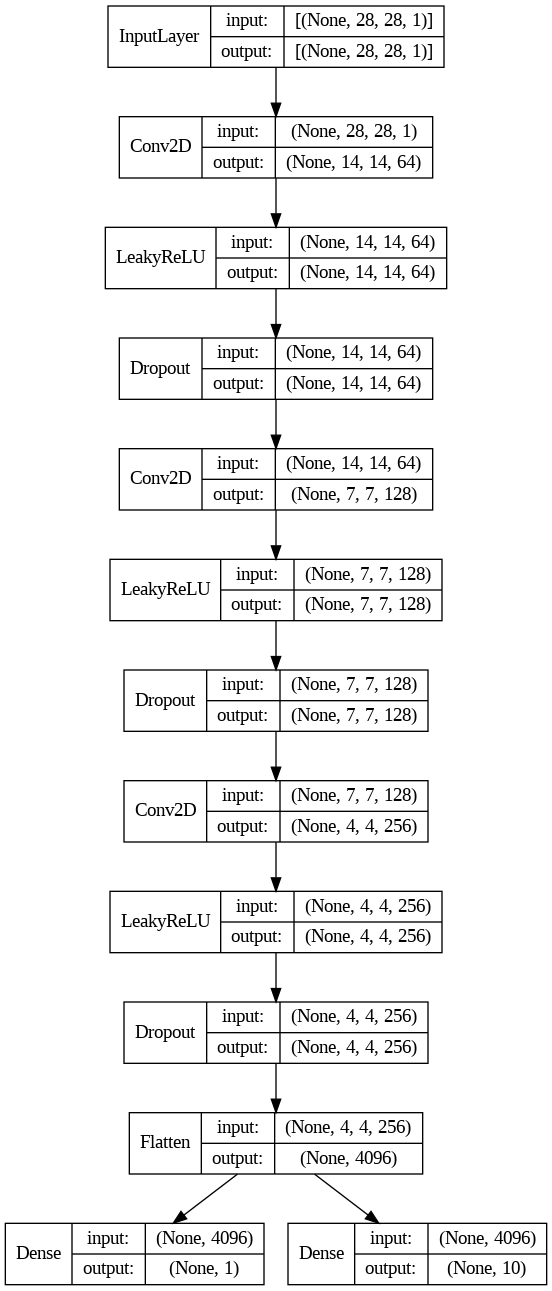

In [32]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# GAN model definition

In [33]:
discriminator.compile(
    loss=['binary_crossentropy', 'categorical_crossentropy'],
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
discriminator.trainable = False

z = Input(shape=(100,))
# Crear una nueva entrada label que tenga tantas dimensiones como clases
label = Input(shape=(10,))

# Introducir al generador las entradas z y label al mismo tiempo
img = generator([z, label])

# Obtener del discriminador las salidas validity y target_label a la vez
validity, target_label = discriminator(img)

# Modificar combined para que el modelo admita ambas entradas y salidas
combined = Model([z, label], [validity, target_label])
# Compilar el modelo para que ahora tenga 2 funciones de pérdida:
    # binary_crossentropy: para la salida de validez
    # categorical_crossentropy: para la salida de clasificación de etiqueta
combined.compile(
    loss=['binary_crossentropy', 'categorical_crossentropy'],  # Validity and label loss
    optimizer=Adam(learning_rate=0.0001)
)

# Training

In [34]:
def generate_random_labels(batch_size, array_length):
    batch = []
    for _ in range(batch_size):
        arr = np.zeros(array_length)

        random_position = random.randint(0, array_length - 1)
        arr[random_position] = 1

        batch.append(arr)

    return np.array(batch)

In [39]:
def train(X_train, y_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            gen_labels = generate_random_labels(batch_size, 10)
            # El generador ahora deberá admitir el noise la mismo tiempo que los gen_labels generados aleatoriamente
            gen_imgs = generator.predict([noise, gen_labels], verbose=0)

            # Las imágenes y sus etiquetas
            imgs = X_train[batch*batch_size : (batch+1)*batch_size]

            # Obtener el batch correspondiente de etiquetas de y_train
            img_labels = y_train[batch * batch_size: (batch + 1) * batch_size]

            # Añadir a las salidas deseadas del discriminador las etiquetas aleatorias y las obtenidas de y_train
            d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, gen_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            sampled_labels = generate_random_labels(batch_size, 10)
            # Añadir como entrada y salida las etiquetas generadas
            g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[3])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[3], g_loss[0]))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels)

        plot_losses(history)

## Plotting functions

In [40]:
def sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].set_title(np.where(gen_labels[i]==1))
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].set_title(np.where(img_labels[i]==1))
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [41]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

----EPOCH 0-----
0 [D loss: 2.9800,	 acc.: 42.19%]	[G loss: 2.9826]


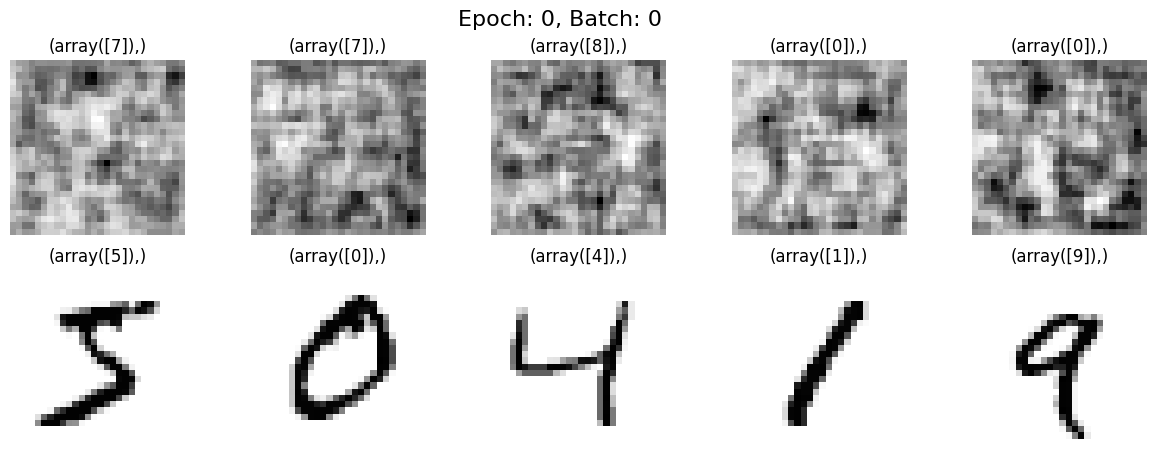

50 [D loss: 2.6557,	 acc.: 50.00%]	[G loss: 2.5111]
100 [D loss: 2.0871,	 acc.: 64.06%]	[G loss: 2.2453]
150 [D loss: 1.3292,	 acc.: 100.00%]	[G loss: 0.6415]
200 [D loss: 0.6286,	 acc.: 100.00%]	[G loss: 0.0691]
250 [D loss: 0.9183,	 acc.: 82.81%]	[G loss: 0.0694]
300 [D loss: 0.9383,	 acc.: 67.19%]	[G loss: 2.1777]
350 [D loss: 1.3441,	 acc.: 51.56%]	[G loss: 0.5431]
400 [D loss: 0.7846,	 acc.: 78.12%]	[G loss: 0.2856]
450 [D loss: 1.2435,	 acc.: 57.81%]	[G loss: 1.3319]
500 [D loss: 0.7555,	 acc.: 82.81%]	[G loss: 0.5681]


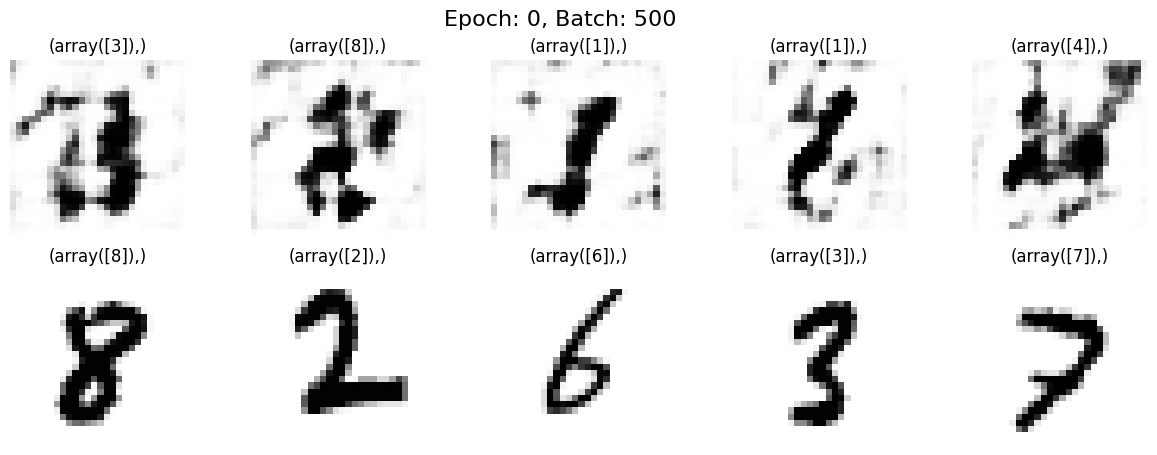

550 [D loss: 0.8014,	 acc.: 75.00%]	[G loss: 0.6761]
600 [D loss: 1.0930,	 acc.: 50.00%]	[G loss: 0.9155]
650 [D loss: 1.0775,	 acc.: 45.31%]	[G loss: 0.8223]
700 [D loss: 0.7991,	 acc.: 70.31%]	[G loss: 0.7605]
750 [D loss: 0.8653,	 acc.: 46.88%]	[G loss: 0.8592]
800 [D loss: 0.7520,	 acc.: 79.69%]	[G loss: 0.9732]
850 [D loss: 0.9050,	 acc.: 62.50%]	[G loss: 0.8914]
900 [D loss: 0.7755,	 acc.: 71.88%]	[G loss: 0.9785]
950 [D loss: 1.1117,	 acc.: 64.06%]	[G loss: 0.7103]
1000 [D loss: 0.9958,	 acc.: 57.81%]	[G loss: 0.8684]


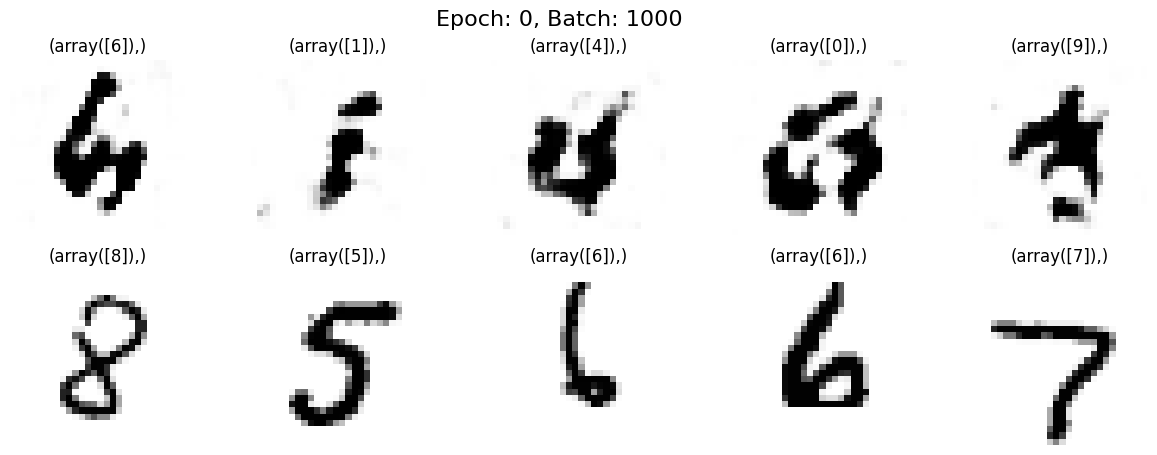

1050 [D loss: 1.1091,	 acc.: 43.75%]	[G loss: 0.9237]
1100 [D loss: 0.8798,	 acc.: 43.75%]	[G loss: 0.8180]
1150 [D loss: 1.0213,	 acc.: 73.44%]	[G loss: 0.7596]


KeyboardInterrupt: 

In [42]:
train(X_train, y_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">